# Get the Data

In [1]:
import pandas as pd

In [2]:
## tell my computer where the data is

DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'

# Train/Test Split

In [3]:
## split data into training and testing
from sklearn.model_selection import train_test_split

train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

train.shape, test.shape

((59400, 41), (14358, 40))

In [4]:
## import more libraries

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Split Train into train and val

In [5]:
## Split train into train & val

from sklearn.model_selection import train_test_split

train, val = train_test_split(train, train_size = 0.80, test_size= 0.20, 
                              stratify = train['status_group'], random_state = 14)
train.shape, val.shape

((47520, 41), (11880, 41))

# Data Wrangling

In [6]:
## I had used my own strategy the past two days and today I want to use
## the wrangle methods used in class

def wrangle(X):
    """Wrangle train, validate, and test sets in the same way"""
    
    # Prevent SettingWithCopyWarning
    X = X.copy()
    
    # Encode latitude
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # replace 0's
    cols_with_zeros = ['longitude', 'latitude', 'construction_year', 
                       'gps_height', 'population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
            
    # Drop duplicate columns
    duplicates = ['quantity_group', 'extraction_type_class', 
                  'extraction_type_group', 'scheme_management', 
                  'payment_type', 'quality_group', 'waterpoint_type_group']
    X = X.drop(columns=duplicates)
    
    # Drop recorded_by (never varies) and id (always varies, random)
    unusable_variance = ['recorded_by', 'id']
    X = X.drop(columns=unusable_variance)
    
    # Convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Extract components from date_recorded, then drop the original column
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    X = X.drop(columns='date_recorded')
    
    # Engineer feature: how many years from construction_year to date_recorded
    X['years'] = X['year_recorded'] - X['construction_year']    
   
    # return the wrangled dataframe
    return X

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

# Arrange data into features matrix and target vector

In [7]:
## identify target vector
target = 'status_group'

In [8]:
## Arrange data into X features matrix and y target vector 
X_train = train.drop(labels = 'status_group', axis = 1)
y_train = train['status_group']
X_val = val.drop(labels = 'status_group', axis = 1)
y_val = val['status_group']
X_test = test

# Create and use a pipeline

In [62]:
## change the pipline
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline


pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='most_frequent'),  
    RandomForestClassifier(n_estimators=72, random_state=14, n_jobs=-1)
)

## Fit on train
pipeline.fit(X_train, y_train)

## Score on val
print('Validation Accuracy', pipeline.score(X_val, y_val))

## Predict on test
y_pred = pipeline.predict(X_val)

Validation Accuracy 0.8073232323232323


# Randomized Cross Validation

In [14]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

In [19]:
from sklearn.metrics import accuracy_score, make_scorer
accuracy_scorer = make_scorer(accuracy_score)

In [31]:
param_distributions = {
    'simpleimputer__strategy': ['mean', 'median', 'most_frequent'], 
    'randomforestclassifier__n_estimators': randint(50, 500), 
    'randomforestclassifier__max_depth': [5, 10, 15, 20, 25, None], 
    'randomforestclassifier__max_features': uniform(0, 1), 
}


search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=100, 
    cv=5, 
    scoring=accuracy_scorer, 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

search.fit(X_train, y_train);

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   29.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 13.2min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 14.2min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 17.0min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 18.5min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed: 21.1min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 24.4min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed: 44.0min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 45

In [32]:
pipeline = search.best_estimator_

In [33]:
y_pred = pipeline.predict(X_test)

(11880,)

In [35]:
df = pd.read_csv('qureshi_submission2.csv')
df.head()

,id,Status_group
0,50785,functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional


In [36]:
(df['Status_group'] == y_pred).value_counts()

True     13590
False      768
Name: Status_group, dtype: int64

In [37]:
df['Status_group'] = y_pred
qureshi_submission = df
qureshi_submission.to_csv('qureshi_submission4.csv', index = False)

# Confusion Matrix

In [48]:
!pip install scikit-plot

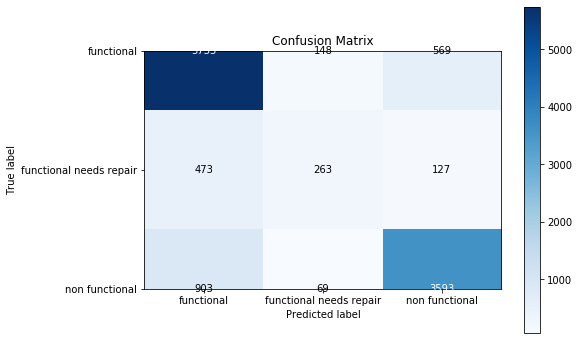

In [65]:
skplt.metrics.plot_confusion_matrix(y_val, y_pred, figsize=(8, 6));

In [64]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_val, y_pred)

array([[5735,  148,  569],
       [ 473,  263,  127],
       [ 903,   69, 3593]])

In [66]:
## accuracy is overall, how often is the classifier correct
## sum the main diagonal and divide by how many total 
(5735 + 263 + 3593)/(5735 + 148 + 569 + 473 + 263 + 127 + 903 + 69 + 3593)

0.8073232323232323

In [67]:
## recall for non functional
## total correct in row / total of row
3593/(3593 + 69 + 903)


0.7870755750273822

In [68]:
## recall for functional needs repair
263/(473 + 263 + 127)

0.3047508690614137

In [69]:
## recall for functional
5735/(5735 + 148 + 569)

0.888871667699938

In [70]:
confusion_matrix(y_val, y_pred)

array([[5735,  148,  569],
       [ 473,  263,  127],
       [ 903,   69, 3593]])

In [71]:
## precision for functional
5735/(5735 + 473 + 903)

0.8064969765152581

In [72]:
## precision for functional needs repair
263/(148 + 263 + 69)

0.5479166666666667

In [73]:
## precision for non-functional
3593/(569 + 127 + 3593)

0.8377244112846818